In [0]:
!pip install pydicom

In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [0]:
import zipfile
with zipfile.ZipFile("BCCD_Dataset-master.zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [4]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes



%matplotlib inline

Using TensorFlow backend.


In [0]:
image_path = 'BCCD_Dataset-master/BCCD/JPEGImages/'
annot_path = 'BCCD_Dataset-master/BCCD/Annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)

In [0]:
train = pd.DataFrame(columns=["image_names", "cell_type", "xmin", "xmax","ymin", "ymax"])

In [0]:
row_count = 0
for img in all_imgs:
  filename=img['filename']
  for cell in img[ 'object'] :
      bbdict = { "image_names" : filename , "cell_type" : cell['name'], "xmin" : cell['xmin'], "xmax": cell['xmax'],"ymin" : cell['ymin'], "ymax": cell['ymax']}
      train.loc[row_count] =bbdict
      row_count+=1

In [0]:

train["x_diff"]=train["xmax"]-train["xmin"]
train=train[train["x_diff"]!=0]

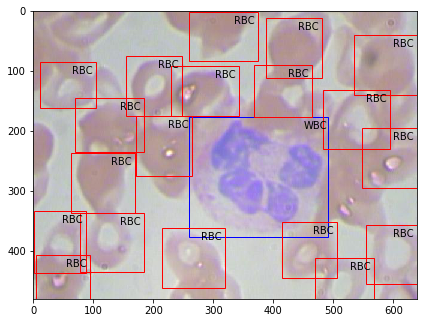

In [9]:

from matplotlib.patches import Rectangle
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
path=train['image_names'].values[5]
image = plt.imread(path)
plt.imshow(image)

for _,row in train[train.image_names == path].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)



In [10]:
print("minimum width :" +str( min([ train.values[i,3] - train.values[i,2] for i in range(train.values.shape[0])] ))  )
print("mean width :" +str( np.mean([ train.values[i,3] - train.values[i,2] for i in range(train.values.shape[0])] ))  )
print("maximum width : " + str(max([ train.values[i,3] - train.values[i,2] for i in range(train.values.shape[0])] )  ))



minimum width :19
mean width :106.64858780188293
maximum width : 338


In [11]:
print("minimum height :" +str( min([ train.values[i,5] - train.values[i,4] for i in range(train.values.shape[0])] ))  )
print("mean height :" +str( np.mean([ train.values[i,5] - train.values[i,4] for i in range(train.values.shape[0])] ))  )
print("maximum height : " + str(max([ train.values[i,5] - train.values[i,4] for i in range(train.values.shape[0])] )  ))



minimum height :23
mean height :101.66741711011052
maximum height : 286


In [0]:
X=[]
y=[]


In [0]:
for i in range(train.values.shape[0]) :
  
  if train.values[i,-1] > 0:
      img_=plt.imread(train.values[i,0]) 
      y1,y2,x1,x2=train.values[i][2:6]
      
      img=img_[x1:x2+1,y1:y2+1]
     
      img=cv2.resize(img, (128,128))
      img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      X.append(img)
      if train.values[i][1] == 'RBC':
            y.append(0)
      elif train.values[i][1] == 'WBC':
            y.append(1)
      elif train.values[i][1] == 'Platelets':
          y.append(2)
  
 


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(np.array(X), test_size=0.2, random_state=42)

In [15]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())

    encoder.add(Dense(code_size*2))
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size*2))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X[0].shape
encoder, decoder = build_autoencoder(IMG_SHAPE, 512)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam',loss='mse')

print(autoencoder.summary())





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512)               50857472  
_________________________________________________________________
sequential_2 (Sequential)    (None, 128, 128, 3)       50906112  
Total params: 101,763,584
Trainable params: 101,763,584
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=[X_test, X_test])




Train on 3908 samples, validate on 978 samples
Epoch 1/10





3908/3908 [==============================] - 8s 2ms/step - loss: 1726622.3192 - val_loss: 6071.4999
Epoch 2/10
3908/3908 [==============================] - 6s 1ms/step - loss: 764.0630 - val_loss: 298.0521
Epoch 3/10
3908/3908 [==============================] - 6s 1ms/step - loss: 281.2474 - val_loss: 288.8197
Epoch 4/10
3908/3908 [==============================] - 6s 1ms/step - loss: 274.5333 - val_loss: 283.7224
Epoch 5/10
3908/3908 [==============================] - 6s 1ms/step - loss: 271.1274 - val_loss: 281.1264
Epoch 6/10
3908/3908 [==============================] - 6s 1ms/step - loss: 268.7115 - val_loss: 278.4319
Epoch 7/10
3908/3908 [==============================] - 6s 1ms/step - loss: 266.8736 - val_loss: 276.0729
Epoch 8/10
3908/3908 [==============================] - 6s 1ms/step - loss: 264.9747 - val_loss: 276.3737
Epoch 9/10
3908/3908 [==============================] - 6s 1ms/step - loss: 266.2128 - val_l

In [0]:
pred=encoder.predict(np.array(X))

In [0]:
import numpy as np
from sklearn.manifold import TSNE
X = encoder.predict(np.array(X))
X_embedded = TSNE(n_components=2).fit_transform(X)


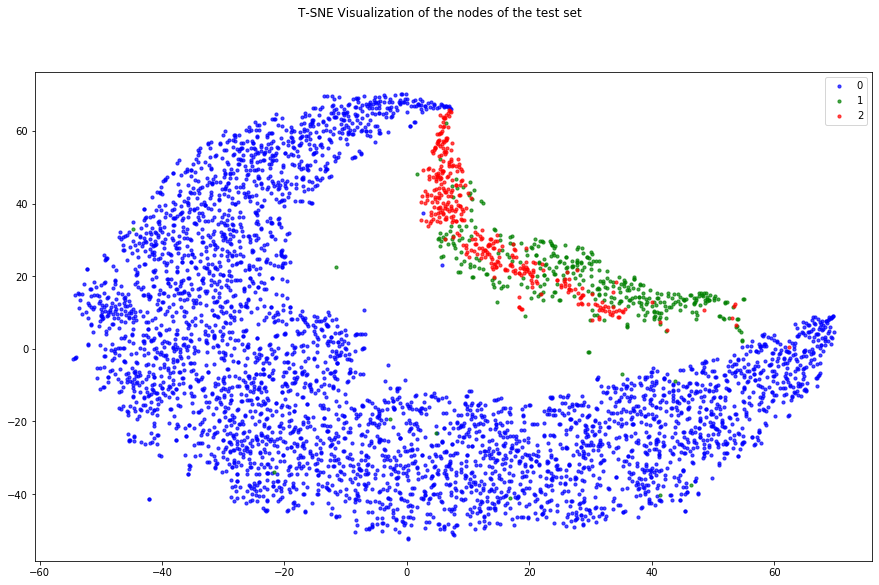

In [20]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots()
for i in range(len(np.unique(y))):
    idxs = [j for j in range(len(y)) if y[j]==i]
    ax.scatter(X_embedded[idxs,0], 
               X_embedded[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization ',fontsize=12)
fig.set_size_inches(15,9)
plt.show()